Units used: GeV for masses, s for time, cm for distances

In [50]:
import glob
import matplotlib as mlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from numpy import loadtxt
import re
import csv
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches

import sys
sys.path.insert(1, '/home/stasya/prj/alps-running/TdAlps-Internal/')
import TdAlps
from collections import OrderedDict

import scipy.integrate as integrate


In [3]:
#Plotting settings
font = {
        'weight' : 'normal',
        'size'   : 16}

mlib.rc('font', **font)

In [31]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [54]:
sm={
    'GF': 1.166*10**(-5),
    'sw': np.sqrt(0.231),
    'hbar': 6.582*10**(-25),
    'c': 3*10**10,
    'alpha': 1/137,
    'Vtb': 0.999,
    'Vts': 0.0404,
    'Xt': 1.469,
    'BrBtoKnunu+': 4.5*10**(-6),
    'NBBBaBar': 471*10**6,
    'NBBBelleII': 5*10**10,
    'me': 0.000511,
    'mmu': 0.1056,
    'mtau': 1.777,
    'mu': 2.2/1000,
    'md': 4.7/1000,
    'ms': 95/1000,
    'mc': 1.275,
    'mb': 4.18,
    'mt': 173,
    'mZ': 91.19,
    'mB+': 5.279,
    'mK+': 0.494,
    'tauB+': 1.638*10**(-12),
    'ctauB+': 3 * 10**10 * 1.638*10**(-12),
    'GammaB+': 6.582*10**(-25)/(10**(-12) * 1.638)
}

In [51]:
BelleIIparams={
    'gammaBoostB': 1.03029,
    'RCDC': 60, #cm
    'thetaCDCMin': np.deg2rad(17),
    'thetaCDCMax': np.deg2rad(150),
    'dres': 0.9,
    'NBBelleII': 5*10**10
}

In [5]:
def f(Lambda):
    return Lambda/(4 * np.pi)

In [24]:
def fz(t):
    tplus = (sm['mB+']+sm['mK+'])**2
    tminus = (sm['mB+']-sm['mK+'])**2
    tzero = tplus * (1-np.sqrt(1-tminus/tplus))
    return (np.sqrt(tplus-t) - np.sqrt(tplus-tzero))/(np.sqrt(tplus-t) + np.sqrt(tplus-tzero))

def formFactorFplusBplus(qsqr):
    tmp = 0.329
    tmp += -0.876 * (fz(qsqr) - fz(0))
    tmp += 0.006 * (fz(qsqr) - fz(0))**2
    tmp = tmp/(1-qsqr/5.325**2)
    return tmp

def formFactorFzeroBplus(qsqr):
    tmp = 0.329
    tmp += 0.195 * (fz(qsqr) - fz(0))
    tmp += -0.446 * (fz(qsqr) - fz(0))**2
    tmp = tmp/(1-qsqr/5.54**2)
    return tmp

## based on https://github.com/rrschaefer/alps (formulas taken from 2012.12272 and 1708.00443)

### Alps running implemented in https://github.com/TdAlps

In [6]:
def getLScoefficients(cff, cww, cbb, Lambda, mu):
    HC = OrderedDict()
    HC['Q'] = np.array([[cff,0,0],[0,cff,0],[0,0,cff]])
    HC['u'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['d'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['L'] = np.array([[cff,0,0],[0,cff,0],[0,0,cff]])
    HC['e'] = np.array([[-cff,0,0],[0,-cff,0],[0,0,-cff]])
    HC['GG'] = 0
    HC['WW'] = cww
    HC['BB'] = cbb
    return TdAlps.RunRotateMatchRun(HC, Lambda, mu, 3)


def getCuu(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][0][0]-coeffs['u'][0][0]

def getCcc(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][1][1]-coeffs['u'][1][1]

def getCtt(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['U'][2][2]-coeffs['u'][2][2]

def getCdd(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][0][0]-coeffs['d'][0][0]

def getCss(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][1][1]-coeffs['d'][1][1]

def getCbb(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][2][2]-coeffs['d'][2][2]

def getCGG(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['GG']

def getCgg(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['gamgam']

def getCee(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][0][0]-coeffs['e'][0][0]

def getCmumu(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][1][1]-coeffs['e'][1][1]

def getCtautau(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['E'][2][2]-coeffs['e'][2][2]

def getCbs(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['D'][2][1]-coeffs['d'][2][1]

def getAlphaEM(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['aEM']

def getAlphaS(cff, cww, cbb, Lambda, mu):
    coeffs = getLScoefficients(cff, cww, cbb, Lambda, mu)
    return coeffs['a3']


def readCuu(coeffs):
    return coeffs['U'][0][0]-coeffs['u'][0][0]

def readCcc(coeffs):
    return coeffs['U'][1][1]-coeffs['u'][1][1]

def readCtt(coeffs):
    return coeffs['U'][2][2]-coeffs['u'][2][2]

def readCdd(coeffs):
    return coeffs['D'][0][0]-coeffs['d'][0][0]

def readCss(coeffs):
    return coeffs['D'][1][1]-coeffs['d'][1][1]

def readCbb(coeffs):
    return coeffs['D'][2][2]-coeffs['d'][2][2]

def readCGG(coeffs):
    return coeffs['GG']

def readCgg(coeffs):
    return coeffs['gamgam']

def readCee(coeffs):
    return coeffs['E'][0][0]-coeffs['e'][0][0]

def readCmumu(coeffs):
    return coeffs['E'][1][1]-coeffs['e'][1][1]

def readCtautau(coeffs):
    return coeffs['E'][2][2]-coeffs['e'][2][2]

def readCbs(coeffs):
    return coeffs['D'][2][1]-coeffs['d'][2][1]

def readAlphaEM(coeffs):
    return coeffs['aEM']

def readAlphaS(coeffs):
    return coeffs['a3']

def printLowScaleCoef(coeffs):
    print("readCuu = {0}\n readCcc = {1}\n readCdd = {2}\n readCss = {3}\n readCbb = {4}\n".format(readCuu(coeffs),readCcc(coeffs),readCdd(coeffs),readCss(coeffs),readCbb(coeffs)))  

In [7]:
testCoeff= getLScoefficients(1, 0.5, 0, 10**3, 50)

In [8]:
readCbb(getLScoefficients(1, 0, 0, 10**3, 5))

(1.9706808739558992+4.357055911013798e-22j)

In [9]:
readCgg(testCoeff)

(0.5+0j)

In [10]:
readAlphaEM(testCoeff)

(0.00965486945987901+0j)

In [11]:
printLowScaleCoef(testCoeff)

readCuu = (1.8703162199567827-1.588421225203518e-24j)
 readCcc = (1.8703162199567827-1.588421225203518e-24j)
 readCdd = (2.0476858760465784-1.688147274833831e-21j)
 readCss = (2.0476618440142937+3.3865449825539148e-21j)
 readCbb = (2.0329718799285375-1.5868064632864805e-24j)



In [12]:
print(readCgg(testCoeff),readCGG(testCoeff))

(0.5+0j) 0j


In [13]:
def nq(ma):
    if ma>2*sm['mt']:
        return 6
    elif ma>=2*sm['mb']:
        return 5
    elif ma>=2*sm['mc']:
        return 4
    elif ma>=2*sm['ms']:
        return 3
    elif ma>=2*sm['md']:
        return 2
    elif ma>=2*sm['mu']:
        return 1
    else:
        return 0

def B2(tau):
    return 1-(tau-1)*funcB(tau)**2

# (14) in 2012.12272
def B1(tau):
    return 1-tau*funcB(tau)**2


def funcB(tau):
    if tau>=1:
        return np.arcsin(1/np.sqrt(tau))
    else:
        return np.pi/2 + 1j/2 * np.log((1+np.sqrt(1-tau))/(1-np.sqrt(1-tau)))

In [14]:
def Gammaatoll(ma, cll, ml, Lambda):
    if ma <= 2 * ml:
        return 0
    gamma = ml**2 * abs(cll)**2 * np.sqrt(ma**2 - 4 * ml**2) / (8 * np.pi * Lambda**2) 
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to leptons with mass " + str(ml) + " is complex: " + str(gamma))
    return float(gamma)

#quark masses depend on scale, not included here
def Gammaatoqq(ma, cqq, mq, Lambda):
    if ma <= 2 * mq:
        return 0
    gamma = 3 * mq**2 * abs(cqq)**2 * np.sqrt(ma**2 - 4 * mq**2) / (8 * np.pi * Lambda**2)
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to quarks with mass " + str(mq) + " is complex: " + str(gamma))
    return float(gamma)

def Gammaatogamgam(ma, coeffs, Lambda):
    cgamgam = readCgg(coeffs)
    alphaEM = readAlphaEM(coeffs)
    effcgg = cgamgam
    if ma >= sm['mZ']:
        effcgg += 2 * alphaEM/np.pi * coeffs['WW']/sm['sw']**2 * B2(4*sm['mW']**2/ma**2)
        effcgg += 3 * (2/3)**2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2)
    if ma>2*sm['mc']:
        effcgg += 3 * (2/3)**2 * readCcc(coeffs) * B1(4*sm['mc']**2/ma**2) 
        
    effcgg += 3 * (2/3)**2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2)
    if ma>2*sm['mb']:
        effcgg += 3 * (-1/3)**2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2)
        effcgg += 3 * (-1/3)**2 * (readCss(coeffs) * B1(4*sm['ms']**2/ma**2) + readCdd(coeffs) \
                               * B1(4*sm['md']**2/ma**2))
    effcgg += readCee(coeffs) * B1(4*sm['me']**2/ma**2) + readCmumu(coeffs) * B1(4*sm['mmu']**2/ma**2)
    if ma>2*sm['mb']:
        effcgg += readCtautau(coeffs) * B1(4*sm['mtau']**2/ma**2)
    gamma = abs(effcgg)**2 * alphaEM**2 * ma**3 /(4 * np.pi * Lambda**2) 
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to photons is complex: " + str(gamma))
    return float(gamma)

def GammaatogamgamMy(ma, coeffs, Lambda):
    cgamgam = readCgg(coeffs)
    alphaEM = readAlphaEM(coeffs)
    effcgg = cgamgam
    # eq. (47) in 2012.12272
    if ma>sm['me']:
        effcgg +=readCee(coeffs) * B1(4*sm['me']**2/ma**2) 
    if ma>sm['mmu']:
        effcgg +=readCmumu(coeffs) * B1(4*sm['mmu']**2/ma**2) 
    if ma>sm['mtau']:
        effcgg +=readCtautau(coeffs) * B1(4*sm['mtau']**2/ma**2)
        
    if ma>sm['mu']:
        effcgg += 3 * (2/3)**2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2) 
    if ma>sm['mc']:
        effcgg += 3 * (2/3)**2 * readCdd(coeffs) * B1(4*sm['mc']**2/ma**2) 
    if ma>sm['mt']:
        effcgg += 3 * (2/3)**2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2) 
        
    if ma>sm['md']:
        effcgg += 3 * (1/3)**2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2) 
    if ma>sm['ms']:
        effcgg += 3 * (1/3)**2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2) 
    if ma>sm['mb']:
        effcgg += 3 * (1/3)**2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2) 
        
    if ma >= sm['mZ']:
        effcgg += 2 * alphaEM/np.pi * coeffs['WW']/sm['sw']**2 * B2(4*sm['mW']**2/ma**2)
        
    # eq.(46) in 2012.12272
    gamma = abs(effcgg)**2 * alphaEM**2 * ma**3 /(64 * np.pi * f(Lambda)**2) 
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to photons is complex: " + str(gamma))
    return float(gamma)
    
    
def Gammaatohad(ma, coeffs, Lambda):
    if ma <= 1:
        return 0
    alphaS = readAlphaS(coeffs)
    cGGeff = readCGG(coeffs)
    cGGeff += 1/2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2)
    cGGeff += 1/2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2)
    cGGeff += 1/2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2)
    if ma>2*sm['mc']:
        cGGeff += 1/2 * readCcc(coeffs) * B1(4*sm['mc']**2/ma**2)
    if ma>2*sm['mb']:
        cGGeff += 1/2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2)
    if ma >= sm['mZ']:
        cGGeff += 1/2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2)
    gamma = abs(cGGeff)**2 * 32 * np.pi * alphaS**2 * ma**3 * \
            (1 + (97/4-7*nq(ma)/6) * alphaS/np.pi)/Lambda**2
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to hadrons is complex: " + str(gamma))
    return float(gamma)

def GammaatohadMyCheck(ma, coeffs, Lambda):
    if ma <= 1:
        return 0
    alphaS = readAlphaS(coeffs)
    cGGeff = readCGG(coeffs)
    
    # eq.(13) in 2012.12272
    
    cGGeff += 1/2 * readCuu(coeffs) * B1(4*sm['mu']**2/ma**2) * np.heaviside(ma-sm['mu'],1)\
            + 1/2 * readCdd(coeffs) * B1(4*sm['md']**2/ma**2) * np.heaviside(ma-sm['md'],1)\
            + 1/2 * readCss(coeffs) * B1(4*sm['ms']**2/ma**2) * np.heaviside(ma-sm['ms'],1)\
            + 1/2 * readCcc(coeffs) * B1(4*sm['mc']**2/ma**2) * np.heaviside(ma-sm['mc'],1)\
            + 1/2 * readCbb(coeffs) * B1(4*sm['mb']**2/ma**2) * np.heaviside(ma-sm['mb'],1)\
            #+ 1/2 * readCtt(coeffs) * B1(4*sm['mt']**2/ma**2) * np.heaviside(ma-sm['mZ'],1)\
        
    # eq.(29) in 1708.00443 with nq=3 light quarks
    gamma = abs(cGGeff)**2 * 32 * np.pi * alphaS**2 * ma**3 * \
            (1 + (97/4-7*nq(ma)/6) * alphaS/np.pi)/Lambda**2
    if gamma.imag  != 0:
        if gamma.imag/gamma.real > 10**-10:
            print("The Decay rate to hadrons is complex: " + str(gamma))
    return float(gamma)

In [15]:
print(Gammaatogamgam(0.5, testCoeff, 10**3),GammaatogamgamMy(0.5, testCoeff, 10**3))

4.9637770073871695e-11 7.063092031412911e-10


<ipython-input-14-b048d09e9d79>:42: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-14-b048d09e9d79>:78: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


In [16]:
print(Gammaatogamgam(5, testCoeff, 10**3),GammaatogamgamMy(5, testCoeff, 10**3))

8.503955864875954e-08 1.4091805951273885e-06


<ipython-input-14-b048d09e9d79>:42: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-14-b048d09e9d79>:78: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


In [15]:
print(Gammaatohad(3, testCoeff, 10**3),GammaatohadMyCheck(3, testCoeff, 10**3))

0.0006651550006344234 0.0006651550006344234


<ipython-input-13-180f5a4b9bb1>:111: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-13-180f5a4b9bb1>:134: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


In [17]:
def Gammaa(ma, cff, cww, cbb, Lambda):
    lscs = getLScoefficients(cff, cww, cbb, Lambda, ma)
    GammaTot = 0
    if ma>2*sm['me']:
        GammaTot += Gammaatoll(ma,readCee(lscs),sm['me'],Lambda)
    if ma>2*sm['mmu']:
        GammaTot += Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda)
    if ma>2*sm['mtau']:
        GammaTot += Gammaatoll(ma,readCtautau(lscs),sm['mtau'],Lambda)
    if ma>2*sm['mc']:
        GammaTot += Gammaatoqq(ma,readCcc(lscs),sm['mc'],Lambda)
    if ma>2*sm['mb']:
        GammaTot += Gammaatoqq(ma,readCbb(lscs),sm['mb'],Lambda)
    if ma>1:
        GammaTot += Gammaatohad(ma,lscs,Lambda)
    GammaTot += Gammaatogamgam(ma,lscs,Lambda)
    if GammaTot.imag  != 0:
        print("The Decay rate to hadrons is complex: " + str(GammaTot))
    return float(GammaTot)

In [45]:
def BrBtoKaplus(ma, cbs, Lambda):
    return abs(cbs)**2/(16 * np.pi * Lambda**2) * abs(formFactorFzeroBplus(ma))**2* (sm['mB+']**2\
    -sm['mK+'])**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4-2*(sm['mB+']**2 * sm['mK+']**2 \
                                    + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))/sm['hbar']*sm['tauB+']

def BrBtoKaplusMyCheck(ma, cbs, Lambda):
    return abs(cbs)**2/(16 * np.pi * Lambda**2) * abs(formFactorFzeroBplus(ma))**2* (sm['mB+']**2\
    -sm['mK+'])**2/sm['mB+']**3 * np.sqrt(sm['mB+']**4+sm['mK+']**4+ma**4-2*(sm['mB+']**2 * sm['mK+']**2 \
                                    + sm['mK+']**2 * ma**2 + ma**2 * sm['mB+']**2))/sm['GammaB+']

In [49]:
BrBtoKaplus(0.3, 1, 10**3)

764400.4958397369

In [47]:
BrBtoKaplusMyCheck(0.3, 1, 10**3)

764400.4958397369

In [169]:
Gammaa(3, 1, 0, 0, 10**3)

<ipython-input-164-0e5cfdde1471>:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-164-0e5cfdde1471>:41: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


0.003261155304571763

In [29]:
def brsALP(cQ,cu,cd,cL,ce,cGG,cWW,cBB,title,Lambda,br=True):
    with HiddenPrints():
        HC = OrderedDict()
        HC['Q'] = np.array([[cQ,0,0],[0,cQ,0],[0,0,cQ]])
        HC['u'] = np.array([[cu,0,0],[0,cu,0],[0,0,cu]])
        HC['d'] = np.array([[cd,0,0],[0,cd,0],[0,0,cd]])
        HC['L'] = np.array([[cL,0,0],[0,cL,0],[0,0,cL]])
        HC['e'] = np.array([[ce,0,0],[0,ce,0],[0,0,ce]])
        HC['GG'] = cGG
        HC['WW'] = cWW
        HC['BB'] = cBB

        maList = list((i*10**(exp-2) for exp in range(-3, 2) for i in range(10, 100)))
        brs = [[],[],[],[],[],[],[],[]]
        for ma in maList:
            lscs = TdAlps.RunRotateMatchRun(HC, Lambda, ma, 3)
            brs[0].append(Gammaatoll(ma,readCee(lscs),sm['me'],Lambda))
            brs[1].append(Gammaatoll(ma,readCmumu(lscs),sm['mmu'],Lambda))
            try:
                ctautau = readCtautau(lscs)
            except IndexError:
                ctautau = 0
            brs[2].append(Gammaatoll(ma,ctautau,sm['mtau'],Lambda))
            try:
                ccc = readCcc(lscs)
            except IndexError:
                ccc = 0
            brs[3].append(Gammaatoqq(ma,ccc,sm['mc'],Lambda))
            try:
                cbb = readCbb(lscs)
            except IndexError:
                cbb = 0
            brs[4].append(Gammaatoqq(ma,cbb,sm['mb'],Lambda))
            brs[5].append(Gammaatogamgam(ma,lscs,Lambda))
            brs[6].append(Gammaatohad(ma,lscs,Lambda))
            brs[7].append(brs[0][-1]+brs[1][-1]+brs[2][-1]+brs[3][-1]+brs[4][-1]+brs[5][-1]+brs[6][-1])
            if (br):
                brs[0][-1] = brs[0][-1]/brs[7][-1]
                brs[1][-1] = brs[1][-1]/brs[7][-1]
                brs[2][-1] = brs[2][-1]/brs[7][-1]
                brs[3][-1] = brs[3][-1]/brs[7][-1]
                brs[4][-1] = brs[4][-1]/brs[7][-1]
                brs[5][-1] = brs[5][-1]/brs[7][-1]
                brs[6][-1] = brs[6][-1]/brs[7][-1]

        fig, ax = plt.subplots() 
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('ma [GeV]')
        if (br):
            ax.set_ylim([2*10**-4,2.5])
            ax.set_xlim([5*10**-4,11])
            ax.set_ylabel('Branching ratio Br(a->X)')
            ax.plot([maList[0],maList[-1]],[1,1],label='all',ls=':') 
        else:
            ax.plot(maList,brs[7],label='total') 
            ax.set_ylabel('Decay rate Gamma(a->X)')
        ax.plot(maList,brs[0],label='electrons') 
        ax.plot(maList,brs[1],label='muons') 
        ax.plot(maList,brs[2],label='taus') 
        ax.plot(maList,brs[3],label='charms') 
        ax.plot(maList,brs[4],label='bottoms') 
        ax.plot(maList,brs[5],label='photons') 
        ax.plot(maList,brs[6],label='hadrons') 
        ax.legend()
        plt.title(title)
    plt.show()

<ipython-input-14-b048d09e9d79>:42: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)
<ipython-input-14-b048d09e9d79>:100: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(gamma)


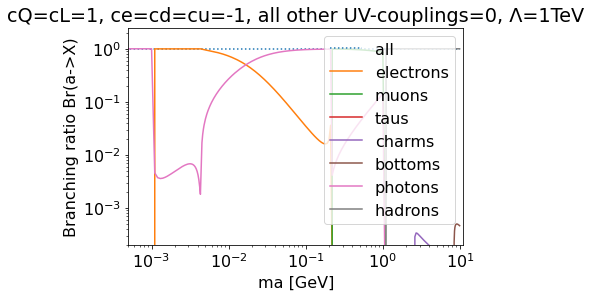

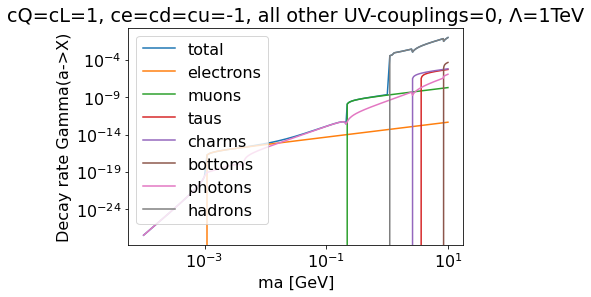

In [32]:
brsALP(1,-1,-1,1,-1,0,0,0,"cQ=cL=1, ce=cd=cu=-1, all other UV-couplings=0, \u039B=1TeV",1000)
brsALP(1,-1,-1,1,-1,0,0,0,"cQ=cL=1, ce=cd=cu=-1, all other UV-couplings=0, \u039B=1TeV",1000,br=False)

## Integral over detector

In [ ]:
def gammaBeta(gammaParent,mParent,ma):
    np.sqrt(gammaParent**2 * (sm['mB+']**2-sm['mK+']+ma**2)/(4*sm['mB+']**2*ma**2)-1)

In [55]:
def thetaMinBoost(thetaMin,r,ctau,gamma):
    return np.arctan(r/(r/np.tan(thetaMin) - gammaBeta * ctau))

def thetaMaxBoost(thetaMin,r,ctau,gamma):
    return np.arctan(r/(r/np.tan(thetaMin) + gammaBeta * ctau))

def geomInt(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta):
    1/(4 * (gammaBeta * ctau)**2) * integrate.quad(lambda theta: (1/np.sin(theta)) \
    * (np.exp(-dmin/(np.sin(theta) * gammaBeta * ctau)) * (dmin**2 + 2 * gammaBeta * ctau * np.sin(theta) * dmin)\
    - np.exp(-dmax/(np.sin(theta) * gammaBeta * ctau)) * (dmax**2 + 2 * gammaBeta * ctau * np.sin(theta) * dmax))\
    , thetaMin, thetaMax)
    
def geomIntBelleIICDC(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta):
    np.heaviside(np.real(BelleIIparams['RCDC']/np.tan(thetaMin)-BelleIIparams['gammaBoostB'] * sm['ctauB+']))\
    * geomInt(thetaMin,thetaMax,dmin,dmax,ctau,gammaBeta)
                                                

## Number of signal events